# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preparing Data

## Loading Data

In [2]:
train = pd.read_csv("/kaggle/input/celestialclassify/train.csv")
test = pd.read_csv("/kaggle/input/celestialclassify/test.csv")

## Replace NaNs

In [3]:
train["rowv"].replace(-9999, np.nan, inplace=True)
train["rowv"].fillna(train["rowv"].mean(), inplace=True)
print(train["rowv"].isnull().sum())

test["colv"].replace(-9999, np.nan, inplace=True)
test["colv"].fillna(test["colv"].mean(), inplace=True)
print(test["colv"].isnull().sum())

0
0


## Standardizing and Creating Train and Test Sets

In [4]:
X_train = train.drop("type", axis=1)
y_train = train["type"]
del train
gc.collect()
X_test = test.drop("type", axis = 1)
y_test = test["type"]
del test
gc.collect()

0

In [5]:
y_train = y_train.apply(lambda x: 1 if x=="star" else 0)
y_test = y_test.apply(lambda x: 1 if x=="star" else 0)

In [6]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

## Some Functions to Evaluate Models

In [7]:
def cm_to_metrics(cm):
    """Calculate accuracy, precision, recall and f1 score from confusion matrix.
    
    Parameters
    ----------
    cm : array-like
        Confusion matrix.
    
    Returns
    -------
    accuracy : float
        Accuracy score.
    precision : float
        Precision score.
    recall : float
        Recall score.
    f1 : float
        F1 score.
    """
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

def evaluate_model(
    model,
    on="train",
    plot_cmat=False,
    verbose=True,
):
    """
    This function evaluates a model and returns the metrics.
    It can be used to evaluate the model on the training set or the test set.
    It can also plot the confusion matrix.
    Parameters
    ----------
    model : object
        The model to be evaluated.
    on : str, optional
        The set on which the model will be evaluated. The default is "train".
    plot_cmat : bool, optional
        Whether to plot the confusion matrix. The default is False.
    verbose : bool, optional
        Whether to print the metrics. The default is True.

    Returns
    -------
    result : dict
        A dictionary with the metrics.
    
    Example
    -------
    >>> result = evaluate_model(model)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test")
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test", plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    """
    if on == "train":
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy, precision, recall, f1 = cm_to_metrics(cm)
    auc_score = roc_auc_score(y, y_pred)

    if plot_cmat:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["star", "galaxy"]
        )
        disp.plot()
        plt.show()
    if verbose:
        try:
            model_name = model.__class__.__name__
        except:
            model_name = ""
        print(f"Accuracy on {on} set of the model {model_name}: {accuracy:.4f}")
        print(f"Precision on {on} set of the model {model_name}: {precision:.4f}")
        print(f"Recall on {on} set of the model {model_name}: {recall:.4f}")
        print(f"F1 on {on} set of the model {model_name}: {f1:.4f}")
        print(f"AUC on {on} set of the model {model_name}: {auc_score:.4f}\n")
        cr = classification_report(y, y_pred)
        print(cr)
    result = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
    }
    return result

# The Models

The goal was to create an ensemble of four models:

1. Support Vector Machine
2. Random Forest
3. XGBClassifier
4. CatBoostClassifier

However, as dataset is huge, training SVM started to become infeasible. Training using `sklearn` as well as `RAPIDS` was taking too much memory and time. So, I decided to drop SVM from the ensemble. This means that the final ensemble is an ensemble of three models.

Here are the best parameters for the models after hyperparameter tuning:

In [8]:
# svc_best_params = {
#     "C": 16296.601892646648,
#     "gamma": 0.0011879874407358082,
#     "kernel": "rbf",
#     "degree": 2,
#     "coef0": 61.32196047340159,
# }

rf_best_params = {
    "n_estimators": 76,
    "max_depth": 19,
    "min_samples_split": 10,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_samples": 1.0,
}

xgb_best_params = {
    "n_estimators": 188,
    "max_depth": 17,
    "learning_rate": 0.08245844777734937,
    "subsample": 0.9,
    "reg_alpha": 0.16634334643800422,
    "reg_lambda": 0.010449329514317554,
    "gamma": 3.5712964675328855e-05,
    "min_child_weight": 17,
}

catb_best_params = {
    "n_estimators": 198,
    "max_depth": 10,
    "learning_rate": 0.009814179840225703,
    "subsample": 0.8,
    "reg_lambda": 0.7960086364994374,
    "min_child_samples": 3,
    "max_bin": 255,
}


## Random Forest

We will be using `RandomForestClassifier` for `cuml` as this supports use of GPU. The parameters will be the same as above:

In [9]:
rfc = RandomForestClassifier(**rf_best_params)
rfc.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestClassifier()

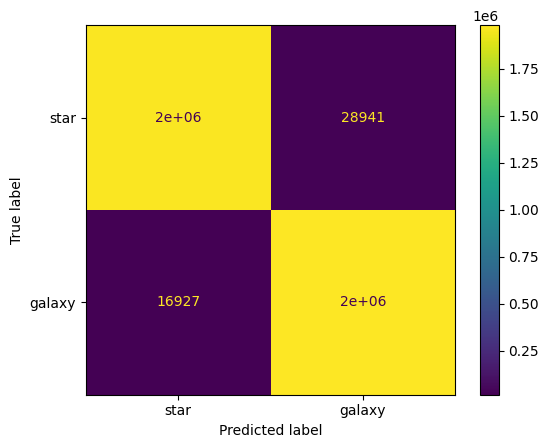

Accuracy on train set of the model RandomForestClassifier: 0.9885
Precision on train set of the model RandomForestClassifier: 0.9856
Recall on train set of the model RandomForestClassifier: 0.9915
F1 on train set of the model RandomForestClassifier: 0.9886
AUC on train set of the model RandomForestClassifier: 0.9885

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1999996
           1       0.99      0.99      0.99   2000004

    accuracy                           0.99   4000000
   macro avg       0.99      0.99      0.99   4000000
weighted avg       0.99      0.99      0.99   4000000



{'accuracy': 0.988533,
 'precision': 0.9856159338534745,
 'recall': 0.9915365169269661,
 'f1': 0.9885673607971243,
 'auc': 0.988532993992954}

In [10]:
evaluate_model(
    rfc,
    on="train",
    plot_cmat=True,
    verbose=True,)

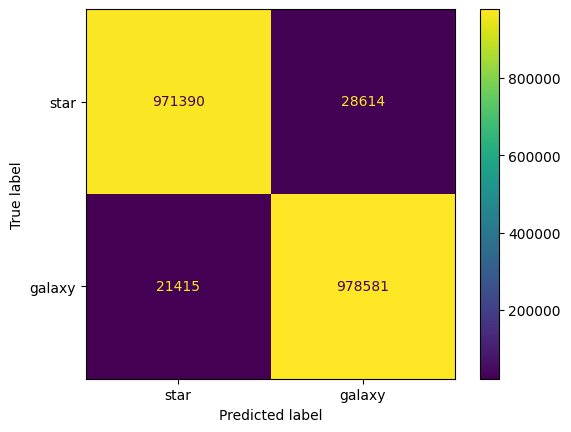

Accuracy on test set of the model RandomForestClassifier: 0.9750
Precision on test set of the model RandomForestClassifier: 0.9716
Recall on test set of the model RandomForestClassifier: 0.9786
F1 on test set of the model RandomForestClassifier: 0.9751
AUC on test set of the model RandomForestClassifier: 0.9750

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1000004
           1       0.97      0.98      0.98    999996

    accuracy                           0.97   2000000
   macro avg       0.98      0.97      0.97   2000000
weighted avg       0.98      0.97      0.97   2000000



{'accuracy': 0.9749855,
 'precision': 0.9715904070214805,
 'recall': 0.9785849143396573,
 'f1': 0.9750751174153331,
 'auc': 0.9749855143975997}

In [11]:
evaluate_model(
    rfc,
    on="test",
    plot_cmat=True,
    verbose=True,)

In [12]:
rfc_score = rfc.score(X_test, y_test)
print(rfc_score)

0.9749854803085327


## XGBoost

Let's train and evaluate the `XGBClassifier` model:

In [13]:
xgbc = XGBClassifier(tree_method='gpu_hist', **xgb_best_params)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.5712964675328855e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08245844777734937, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              n_estimators=188, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

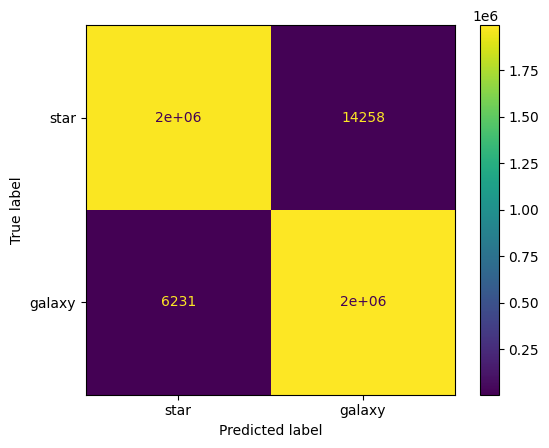

Accuracy on train set of the model XGBClassifier: 0.9949
Precision on train set of the model XGBClassifier: 0.9929
Recall on train set of the model XGBClassifier: 0.9969
F1 on train set of the model XGBClassifier: 0.9949
AUC on train set of the model XGBClassifier: 0.9949

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1999996
           1       0.99      1.00      0.99   2000004

    accuracy                           0.99   4000000
   macro avg       0.99      0.99      0.99   4000000
weighted avg       0.99      0.99      0.99   4000000



{'accuracy': 0.99487775,
 'precision': 0.9928995120095258,
 'recall': 0.9968845062309876,
 'f1': 0.9948880186924516,
 'auc': 0.9948777459864795}

In [14]:
evaluate_model(
    xgbc,
    on="train",
    plot_cmat=True,
    verbose=True,)

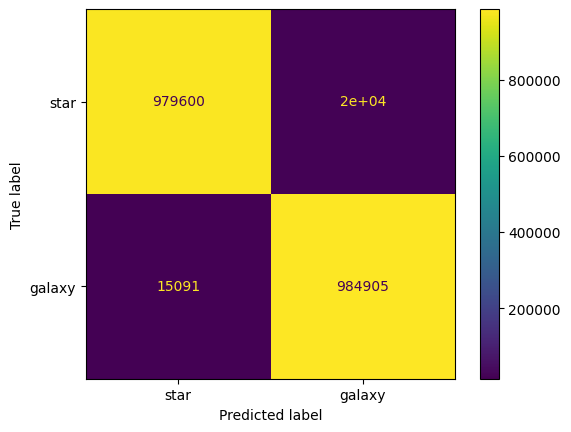

Accuracy on test set of the model XGBClassifier: 0.9823
Precision on test set of the model XGBClassifier: 0.9797
Recall on test set of the model XGBClassifier: 0.9849
F1 on test set of the model XGBClassifier: 0.9823
AUC on test set of the model XGBClassifier: 0.9823

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1000004
           1       0.98      0.98      0.98    999996

    accuracy                           0.98   2000000
   macro avg       0.98      0.98      0.98   2000000
weighted avg       0.98      0.98      0.98   2000000



{'accuracy': 0.9822525,
 'precision': 0.9797037527765096,
 'recall': 0.9849089396357585,
 'f1': 0.9822994507069996,
 'auc': 0.9822525106257161}

In [15]:
evaluate_model(
    xgbc,
    on="test",
    plot_cmat=True,
    verbose=True,)

In [16]:
xgbc_score = xgbc.score(X_test, y_test)
print(xgbc_score)

0.9822525


We can see that the model is performing quite good. It has a test accuracy of over 98%!

## CatBoost

Here are the best parameters for the `CatBoostClassifier` model:

> We have to change `bootstrap_type="Poisson"` as the default value of `bootstrap_type` is `Bayesian`. And, `Bayesian` is not supported for GPU training.

In [17]:
ctbc = CatBoostClassifier(task_type='GPU', bootstrap_type="Poisson", **catb_best_params)
ctbc.fit(X_train, y_train, verbose = True)

0:	learn: 0.6634076	total: 74ms	remaining: 14.6s
1:	learn: 0.6350318	total: 143ms	remaining: 14s
2:	learn: 0.6078244	total: 205ms	remaining: 13.3s
3:	learn: 0.5815051	total: 266ms	remaining: 12.9s
4:	learn: 0.5570651	total: 340ms	remaining: 13.1s
5:	learn: 0.5341757	total: 402ms	remaining: 12.9s
6:	learn: 0.5120581	total: 465ms	remaining: 12.7s
7:	learn: 0.4923605	total: 528ms	remaining: 12.5s
8:	learn: 0.4724301	total: 594ms	remaining: 12.5s
9:	learn: 0.4530380	total: 658ms	remaining: 12.4s
10:	learn: 0.4352311	total: 723ms	remaining: 12.3s
11:	learn: 0.4181941	total: 784ms	remaining: 12.2s
12:	learn: 0.4023426	total: 849ms	remaining: 12.1s
13:	learn: 0.3872077	total: 912ms	remaining: 12s
14:	learn: 0.3730884	total: 974ms	remaining: 11.9s
15:	learn: 0.3593353	total: 1.04s	remaining: 11.8s
16:	learn: 0.3463585	total: 1.1s	remaining: 11.7s
17:	learn: 0.3340639	total: 1.17s	remaining: 11.7s
18:	learn: 0.3229556	total: 1.23s	remaining: 11.6s
19:	learn: 0.3122961	total: 1.29s	remaining: 11

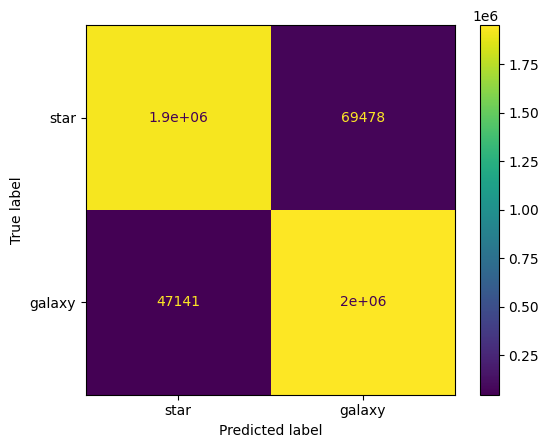

Accuracy on train set of the model CatBoostClassifier: 0.9708
Precision on train set of the model CatBoostClassifier: 0.9656
Recall on train set of the model CatBoostClassifier: 0.9764
F1 on train set of the model CatBoostClassifier: 0.9710
AUC on train set of the model CatBoostClassifier: 0.9708

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1999996
           1       0.97      0.98      0.97   2000004

    accuracy                           0.97   4000000
   macro avg       0.97      0.97      0.97   4000000
weighted avg       0.97      0.97      0.97   4000000



{'accuracy': 0.97084525,
 'precision': 0.965644765150882,
 'recall': 0.9764295471409057,
 'f1': 0.9710072109677315,
 'auc': 0.9708452388313833}

In [18]:
evaluate_model(
    ctbc,
    on="train",
    plot_cmat=True,
    verbose=True,)

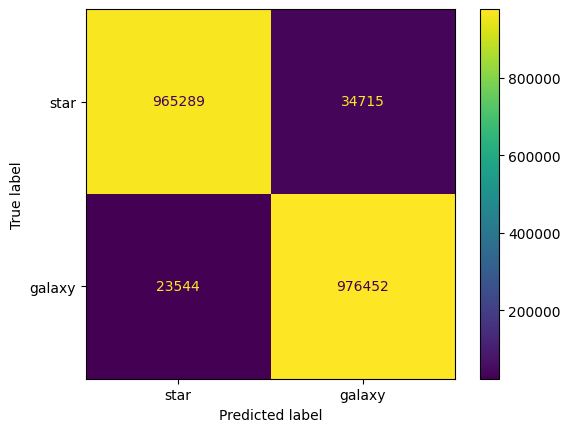

Accuracy on test set of the model CatBoostClassifier: 0.9709
Precision on test set of the model CatBoostClassifier: 0.9657
Recall on test set of the model CatBoostClassifier: 0.9765
F1 on test set of the model CatBoostClassifier: 0.9710
AUC on test set of the model CatBoostClassifier: 0.9709

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1000004
           1       0.97      0.98      0.97    999996

    accuracy                           0.97   2000000
   macro avg       0.97      0.97      0.97   2000000
weighted avg       0.97      0.97      0.97   2000000



{'accuracy': 0.9708705,
 'precision': 0.9656683811872816,
 'recall': 0.9764559058236233,
 'f1': 0.9710321838657532,
 'auc': 0.9708705223415339}

In [19]:
evaluate_model(
    ctbc,
    on="test",
    plot_cmat=True,
    verbose=True,)

In [20]:
ctbc_score = ctbc.score(X_test, y_test)
print(ctbc_score)

0.9708705


Catboost also performs quite well. It has a test accuracy of over 97%! Though, it is slightly worse than XGBoost.

# Creating Ensemble

Let's create an ensemble of these three models and see how it performs:

In [21]:
def evaluate_ensemble(models, X, y, voting="soft"):
    """Evaluates an ensemble of models on a given dataset.

    Parameters
    ----------
    models : list of models
        The list of models to evaluate.
    X : array-like of shape (n_samples, n_features)
        The input samples.
    y : array-like of shape (n_samples,)
        The target values.
    voting : str, default="soft"
        The type of voting to use. Can be either "soft" or "hard".

    Returns
    -------
    preds : ndarray of shape (n_samples,)
        The ensemble predictions.
    """
    # Initialize an array to store the predictions for each model
    preds = np.zeros((len(models), len(X)))

    # Make predictions for each model
    for i, model in tqdm(enumerate(models), "Predicting..."):
        if voting == "soft":
            preds[i] = model.predict_proba(X)[:, 1]
        else:
            preds[i] = model.predict(X)

    # Compute the ensemble prediction based on the voting type
    preds = np.round(np.mean(preds, axis=0))

    # Compute the accuracy of the ensemble prediction
    acc = np.mean(preds == y)

    return preds, acc

In [22]:
models = [rfc, xgbc, ctbc]
soft_preds, soft_score = evaluate_ensemble(models, X_test, y_test, "soft")
hard_preds, hard_score = evaluate_ensemble(models, X_test, y_test, "hard")

Predicting...: 3it [00:33, 11.12s/it]
Predicting...: 3it [00:33, 11.24s/it]


In [23]:
print(f"RandomForest : {rfc_score} | XGBoost: {xgbc_score} | Catboost: {ctbc_score} | Soft Ensemble: {soft_score} | Hard Ensemble {hard_score}")

RandomForest : 0.9749854803085327 | XGBoost: 0.9822525 | Catboost: 0.9708705 | Soft Ensemble: 0.97929 | Hard Ensemble 0.976249


It looks like XGBoost alone is giving the most accurate result! Furthermore, soft voting is giving better results than hard voting.